In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#plot_n_b_psth.ipynb
#plot neural and behavior psth

import scipy.io as sio
import scipy.stats as sio_stat
import scipy.interpolate
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt 

import os
import pickle
import sys
import copy

import time
import pylab as pl
from IPython import display

from bmi_dynamics_code import behavior_co_obs as bmi_b
from bmi_dynamics_code import data_for_v as preeyacode
from bmi_dynamics_code import util as bmi_util

import timeit
from sklearn import decomposition as skl_decomp

import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.linear_model import LinearRegression

%matplotlib notebook

In [3]:
%matplotlib notebook

In [4]:
# data_dir = '/Users/vivekathalye/Dropbox/Code/preeya_co_obstacle'
save_dir = r'D:\Dropbox\BMI_co_obs_paper\data\vivek\command_activity_diff'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
ext_list =['.png', '.eps']

home_dir = r'D:\Dropbox\Code\preeya_co_obstacle'
data_dir = r'D:\Dropbox\Data\preeya_co_obstacle'
data_path = os.path.join(data_dir, 'for_v_df.pkl')
print(os.path.exists(data_path))
d = pickle.load(open(data_path))

#UNPACK: 
decoder = d['decoder']
pre = d['pre']
num_targets = d['num_targets']
sample_period = d['sample_period']
target_hold_time = d['target_hold_time']
num_neurons = d['num_neurons']
target_color = d['target_color']
obs_big = d['obs_big']
obs_small = d['obs_small']
target_r_task = d['target_r_task'] #target_r_task = {0:1.7, 1:2.0}
cursor_r = d['cursor_r']
target_r_eff = d['target_r_eff']
target_pos = d['target_pos']
target_angle = np.arctan2(target_pos[:,1], target_pos[:,0])
target_dist = np.linalg.norm(target_pos, axis=1)
obs_pos = d['obs_pos']

tc_meta = d['tc_meta']
task_list = d['task_list']
num_tasks = len(task_list)
task2idx = d['task2idx']
idx2task = bmi_util.invert_dic(task2idx)
task2tc = d['task2tc']
tc_list = d['tc_list']
df = d['df']
df_label = d['df_label']

task_color = ['k', 'r']

True


In [5]:
#Pre-processing: 

bmi_b.preprocess_bmi_df(df, target_pos, pre, num_tasks, num_targets)
num_cw = 2
cw_label = ['cw', 'ccw']
task_rot_list = [0,1.1,1.2]

#Binning: 
#MAGNITUDE:
num_mag_bins = 5
num_mag_bins_analyze = 4
# mag_bin_perc = np.array([0,25,50,75,100])
mag_bin_perc = np.concatenate([np.linspace(0,95,5),np.array([100])])
#ANGLE:
num_angle_bins = 8
T0_angle = -3*(2*np.pi)/8
mag_bin, mag_bin_edges, mag_bin_c, angle_bin_c, angle_bin, angle_bin_edges =\
bmi_b.def_command_bin(df, mag_bin_perc, num_angle_bins, T0_angle)
#CENTER ANGLE DATA FOR BINNING (based on bin boundaries): 
angle_center_for_binning = bmi_b.df_center_angle_for_binning(df, angle_bin)
#BIN: 
bmi_b.df_bin_command(df, mag_bin_edges,angle_bin_edges)

#Pre-processing continued:

#Center angles to command bin, target: 
bmi_b.center_df_angle(df, angle_bin_c, target_angle)

('angle_center:', 22.5)
('min centered angle:', -157.47162455426732)
('max centered angle:', 202.46708261619673)


<IPython.core.display.Javascript object>


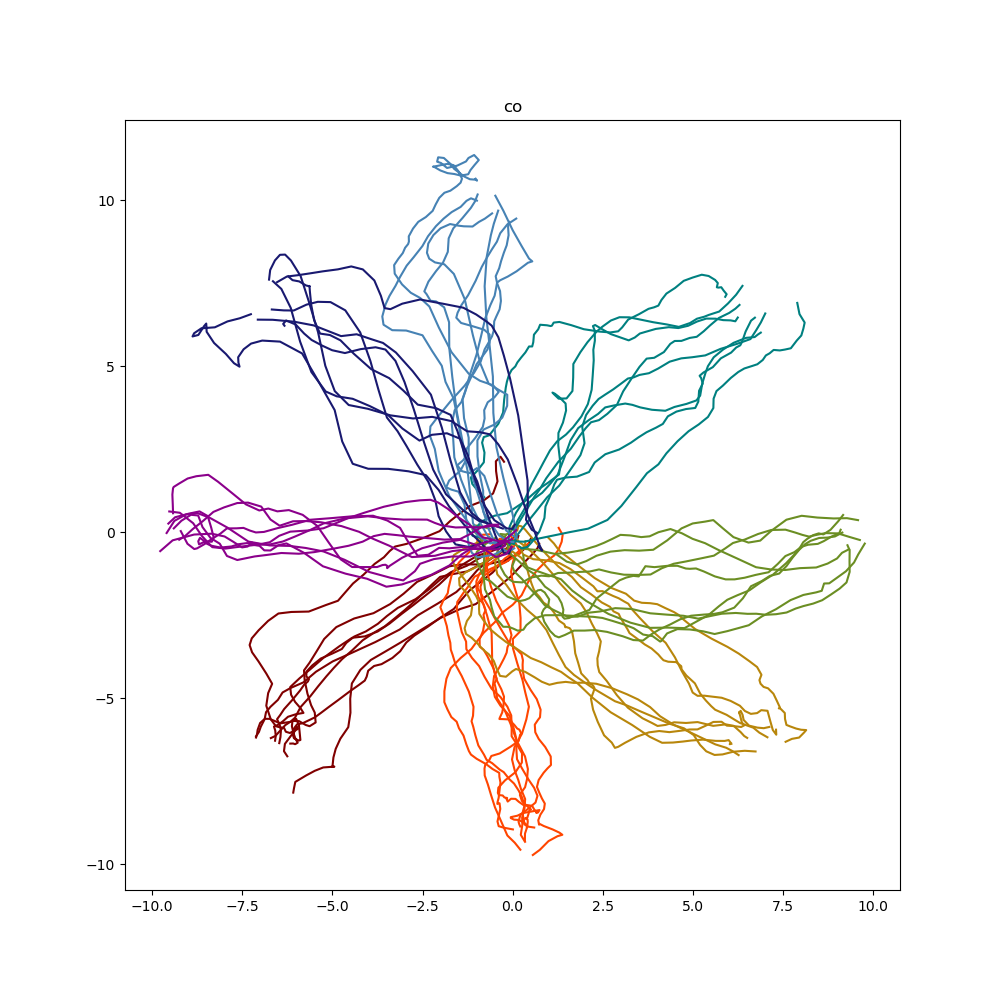

<IPython.core.display.Javascript object>


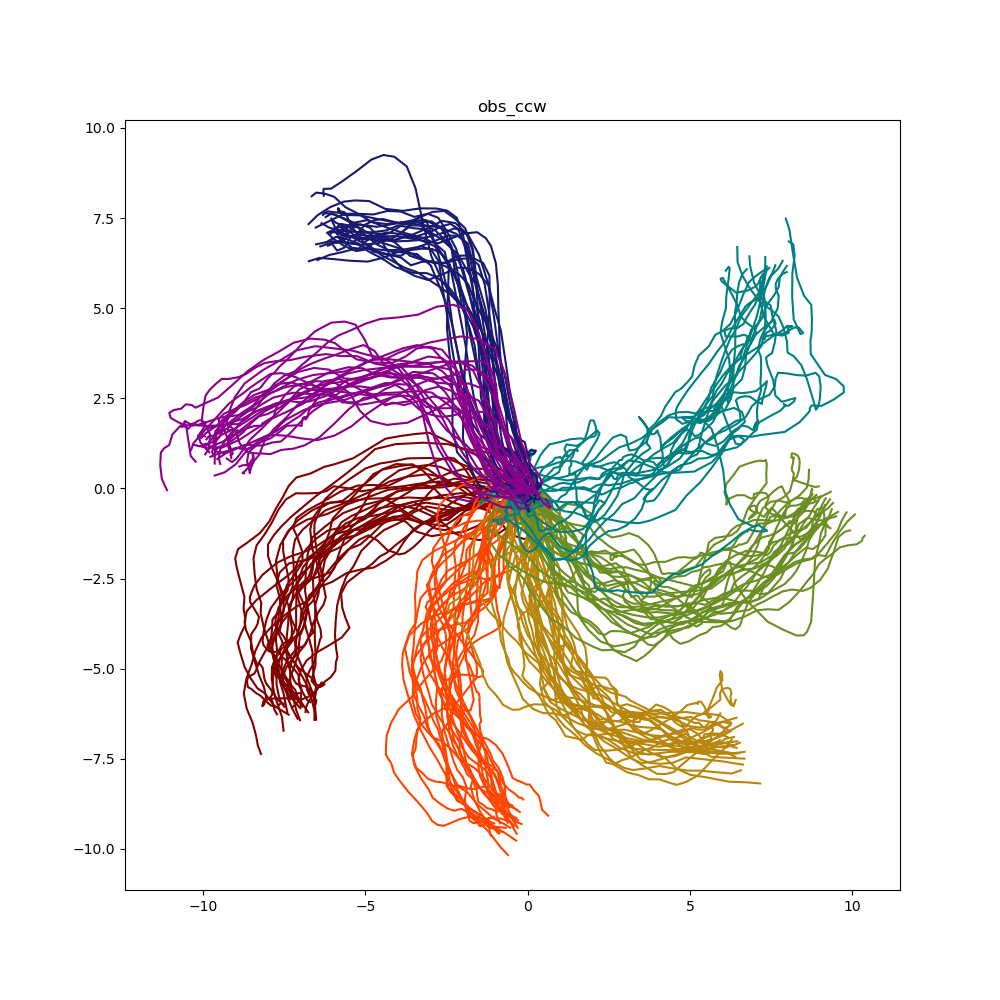

<IPython.core.display.Javascript object>


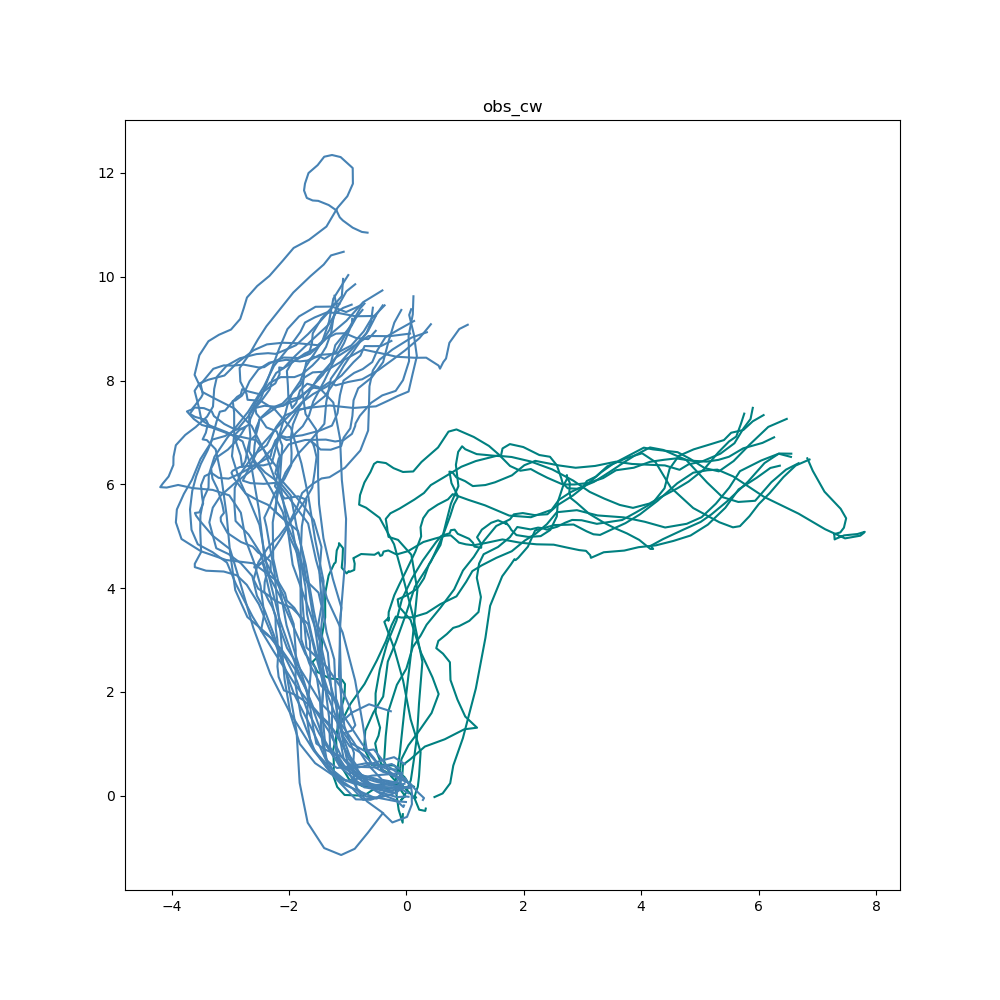

In [6]:
#Plot cw vs ccw trials, to confirm: 
plot = {}
plot['size'] = (10,10)
plot['xlim'] = (-12.5,12.5)
plot['ylim'] = (-12.5,12.5)
task_rot_list = [0,1.1,1.2]
task_rot_label = ['co','obs_ccw', 'obs_cw']

for i,task in enumerate(task_rot_list):
    plt.figure(figsize=plot['size'])
    plt.title(task_rot_label[i])
    for target in range(num_targets):    
            sel = (df['task_rot']==task) & (df['bin']>=0) & (df['target']==target)
            df_sel = df[sel]
            #------------------------------------------------------------------------------------
            #TRIALS: 
            trial_start = np.where(df_sel['bin']==0)[0]
            trial_stop = np.where(df_sel['bin_end']==0)[0]
            trial_bound = np.vstack((trial_start,trial_stop)).T
            #------------------------------------------------------------------------------------
            for bnd in trial_bound[:,:]: #trial_bound[0:1,:]:
    #             if (task_str == 'co') or (task_str == 'obs') and (df_sel['obs_size'][bnd[0]:bnd[0]+1] == obs_big).bool(): 
                x = df_sel['kin_px'][bnd[0]:bnd[1]+1]
                y = df_sel['kin_py'][bnd[0]:bnd[1]+1]
                color = target_color[target]
                plt.plot(x,y,'-',color=color)

<IPython.core.display.Javascript object>


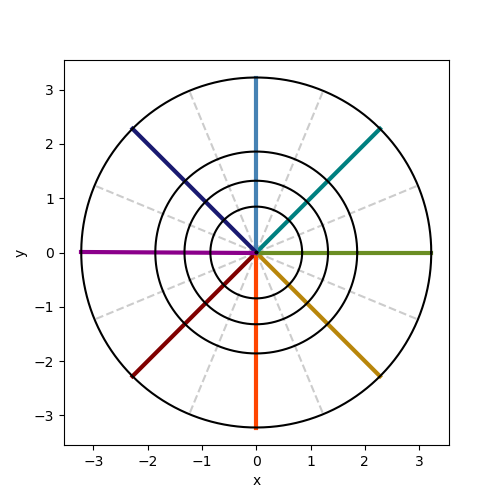

In [7]:
num_mag_bins_analyze=4
def plot_command_bin(): 
    bmi_b.plot_polar_bins(angle_bin_edges, mag_bin_edges[:,:(num_mag_bins_analyze)], target_color)
    
plt.figure(figsize=(5,5))
plot_command_bin()    

### Plot an example trial

<IPython.core.display.Javascript object>


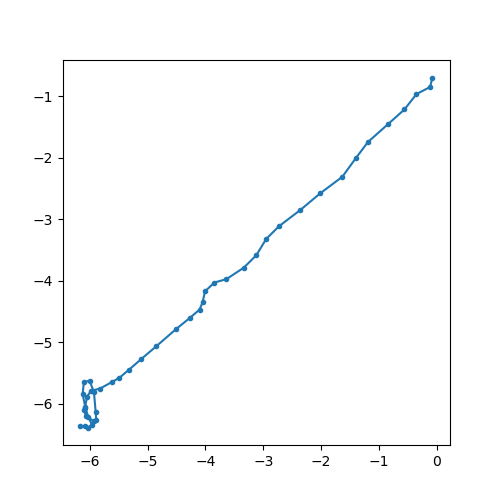

In [8]:
trial = 1

sel_trial = (df['trial_global']==trial)
sel_bin = (df['bin']>=0)
sel = sel_trial&sel_bin

x = df.loc[sel, 'kin_px']
y = df.loc[sel, 'kin_py']

plt.figure(figsize=(5,5))
plt.plot(x,y, '.-')

In [9]:
#----------------------------------------------------------------------------------------------------
#form the cursor state
#kin_px, kin_py, kin_vx, kin_vy, offset
kin_var = ['kin_px', 'kin_py', 'kin_vx', 'kin_vy', 'offset']
num_var = len(kin_var)
obs = df.loc[sel, 'bin'] #np.where(sel)[0]
num_obs = len(obs)

nan_mat = np.ones((num_var, num_obs))*np.nan
kin = xr.DataArray(nan_mat, coords={'v':kin_var, 'obs':obs}, dims=['v','obs'])

#ASSIGN: 
a_var = ['kin_px', 'kin_py', 'kin_vx', 'kin_vy']
kin.loc[a_var,:] = df.loc[sel, a_var].T
kin.loc['offset',:] = 1


obs_t = np.arange(obs.iloc[0], obs.iloc[-2])
kin_t = kin.loc[:, obs_t]

obs_tp1 = np.arange(obs.iloc[1], obs.iloc[-1])
kin_tp1 = kin.loc[:, obs_tp1]


#----------------------------------------------------------------------------------------------------
#neural activity: 
#In future, handle the last sample for predicting next neural activity 

n_list = ['n_'+str(i) for i in range(num_neurons)]
n = df.loc[sel, n_list]
obs = df.loc[sel,'bin']

n_t_df = n.iloc[1:-1,:]
n_t = xr.DataArray(np.array(n_t_df).T, coords={'n':n_list, 'obs':obs_t}, dims=['n', 'obs'])

n_tp1_df = n.iloc[2:,:]
n_tp1 = xr.DataArray(np.array(n_tp1_df).T, coords={'n':n_list, 'obs':obs_tp1}, dims=['n', 'obs'])


In [10]:
#F: 5x5
sel_F = np.array([0,2,3,5,6])
F = decoder['F'][sel_F, :]
F = F[:,sel_F]
print(F.shape)
F = xr.DataArray(F, coords={'out':kin_var, 'in':kin_var}, dims=['out', 'in'])

#K: 5xnum_neurons
sel_K = np.array([0,2,3,5,6])
K = decoder['K'][sel_K, :]

(5L, 5L)


In [200]:
F

<xarray.DataArray (out: 5, in: 5)>
array([[ 1.      ,  0.      ,  0.07    ,  0.      ,  0.017673],
       [ 0.      ,  1.      ,  0.      ,  0.07    , -0.011618],
       [ 0.      ,  0.      ,  0.5     ,  0.      ,  0.176733],
       [ 0.      ,  0.      ,  0.      ,  0.5     , -0.116184],
       [ 0.      ,  0.      ,  0.      ,  0.      ,  1.      ]])
Coordinates:
  * in       (in) |S6 'kin_px' 'kin_py' 'kin_vx' 'kin_vy' 'offset'
  * out      (out) |S6 'kin_px' 'kin_py' 'kin_vx' 'kin_vy' 'offset'

In [21]:
B

array([[0, 0],
       [0, 0],
       [1, 0],
       [0, 1],
       [0, 0]])

In [14]:
#Let's just velocity control the cursor to center out. 
#Define: A,B,Q,R
#A,B:
A = F
B = np.array([[0,0,1,0,0],[0,0,0,1,0]]).T

In [15]:
print(A)

<xarray.DataArray (out: 5, in: 5)>
array([[ 1.      ,  0.      ,  0.07    ,  0.      ,  0.017673],
       [ 0.      ,  1.      ,  0.      ,  0.07    , -0.011618],
       [ 0.      ,  0.      ,  0.5     ,  0.      ,  0.176733],
       [ 0.      ,  0.      ,  0.      ,  0.5     , -0.116184],
       [ 0.      ,  0.      ,  0.      ,  0.      ,  1.      ]])
Coordinates:
  * in       (in) |S6 'kin_px' 'kin_py' 'kin_vx' 'kin_vy' 'offset'
  * out      (out) |S6 'kin_px' 'kin_py' 'kin_vx' 'kin_vy' 'offset'


In [16]:
#Q,R:
#State Cost Q: 
state_dim = 5
# Q = np.eye(state_dim)
Q = np.zeros((state_dim,state_dim))
# #set values for cursor position: 
Q[0,0] = 1
Q[1,1] = 1

#Input Cost R:
input_dim = 2
R_scalar = 1e3
R = np.eye(input_dim)*R_scalar
print(Q)
print(R)

[[1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
[[1000.    0.]
 [   0. 1000.]]


### Solve K 

In [208]:
# #Check consequence of offset column:
# A = copy.deepcopy(F)
# A[:,-1]=0
# A[-1,-1] = 1
# print(F)
# print(A)

<xarray.DataArray (out: 5, in: 5)>
array([[ 1.      ,  0.      ,  0.07    ,  0.      ,  0.017673],
       [ 0.      ,  1.      ,  0.      ,  0.07    , -0.011618],
       [ 0.      ,  0.      ,  0.5     ,  0.      ,  0.176733],
       [ 0.      ,  0.      ,  0.      ,  0.5     , -0.116184],
       [ 0.      ,  0.      ,  0.      ,  0.      ,  1.      ]])
Coordinates:
  * in       (in) |S6 'kin_px' 'kin_py' 'kin_vx' 'kin_vy' 'offset'
  * out      (out) |S6 'kin_px' 'kin_py' 'kin_vx' 'kin_vy' 'offset'
<xarray.DataArray (out: 5, in: 5)>
array([[1.  , 0.  , 0.07, 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.07, 0.  ],
       [0.  , 0.  , 0.5 , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.5 , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 1.  ]])
Coordinates:
  * in       (in) |S6 'kin_px' 'kin_py' 'kin_vx' 'kin_vy' 'offset'
  * out      (out) |S6 'kin_px' 'kin_py' 'kin_vx' 'kin_vy' 'offset'


In [58]:
A = np.mat(A)
B = np.mat(B)
Q = np.mat(Q)
R = np.mat(R)   
Q_f = Q*1e5
T = 100
K = bmi_b.dlqr(A,B,Q,R,Q_f=Q_f,T=T,max_iter=1e5)



### lqr to target state

In [59]:
#Target and Initial State:
#--------------------------------------------------------------------

#Task:
target_r = target_r_task[0]
hold_req = 2

#Target: 
target = np.unique(df.loc[sel,'target']).astype(int)
Tp = np.squeeze(target_pos[target,:])
state_T = np.mat([Tp[0], Tp[1], 0, 0, 0]).T


#Initial state
state_label = kin_var
state_init = np.mat([0,0,0,0,1]).T
state_e_init = state_init-state_T
state_e_list = []
state_e = state_e_init
state_e_list.append(state_e)

#Input:
input_label = ['u_vx', 'u_vy']
u_list = []

#Simulate trial: 
trial_complete = False
sim_len = 0
hold_i = 0

for t in range(0,T-1):
    state_e = (A+B*K[0,t])*state_e

    # state_e = (A-B*K[0,t])*state_e
    # state_e = (A+B*K[t])*state_e
    state_e_list.append(state_e)

    u = K[0,t]*state_e
    # u = -K[0,t]*state_e
    # u = K[t]*state_e
    u_list.append(u)

    if not trial_complete:
        sim_len+=1
        dist2target = np.linalg.norm(state_e[0:2])
        if dist2target <= target_r:
            hold_i+=1
        else:
            hold_i=0
        if(hold_i>=hold_req):
            trial_complete = True

#RESULTS:
#input:
u_mat = np.array(u_list).squeeze().T
u_da = xr.DataArray(u_mat, coords={'v':input_label,'obs':np.arange(T-1)}, dims=['v', 'obs'])

#state error:
state_e_mat = np.array(state_e_list).squeeze().T
# state_e_mat = state_e_mat.squeeze().T
state_e_da = xr.DataArray(state_e_mat, coords={'v':state_label,'obs':np.arange(T)}, dims=['v', 'obs'])

#state:
state_mat = copy.deepcopy(state_e_mat)
state_mat[0:2,:] = state_mat[0:1,:] + state_T[0:2,:] #add the target kinematic state back to the error
state_da = xr.DataArray(state_mat, coords={'v':state_label,'obs':np.arange(T)}, dims=['v', 'obs'])             

### Plot results

<IPython.core.display.Javascript object>


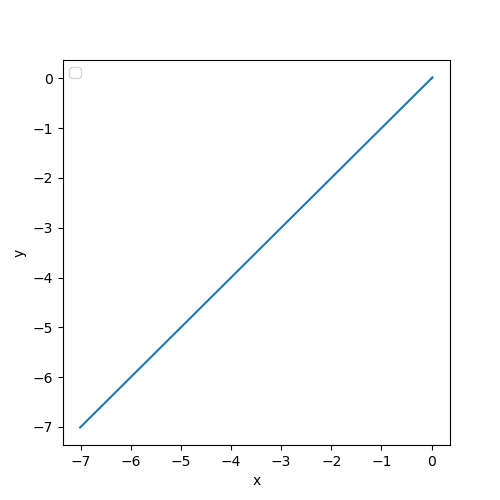

<IPython.core.display.Javascript object>


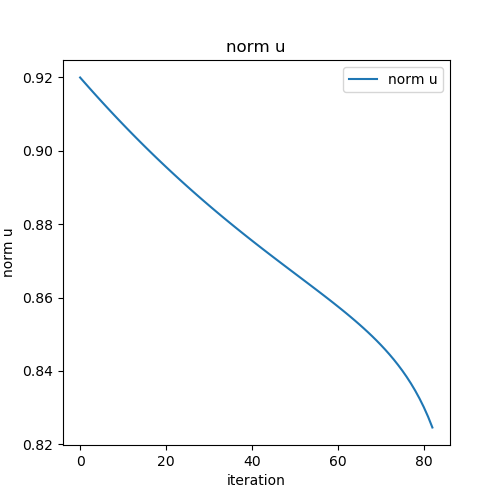

In [60]:
num_plot = T #num_iter
x = state_da.loc['kin_px',np.arange(0,num_plot)]
y = state_da.loc['kin_py',np.arange(0,num_plot)]
# x = state_da.loc['kin_px',:]
# y = state_da.loc['kin_py',:]

# #each coordinate: 
# plt.figure(figsize=(5,5))
# plt.plot(x,'-',label='x')
# plt.plot(y,'-',label='y')
# plt.xlabel('iteration')
# plt.ylabel('cursor position')
# plt.legend()

#trajectory
plt.figure(figsize=(5,5))
plt.plot(x,y,'-')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

#------------------------------------------------------------
#input: 
num_plot = sim_len
x = u_da.loc['u_vx',np.arange(0,num_plot)]
y = u_da.loc['u_vy',np.arange(0,num_plot)]

# #each coordinate: 
# plt.figure(figsize=(5,5))
# plt.plot(x,'-',label='u_vx')
# plt.plot(y,'-',label='u_vy')
# plt.xlabel('iteration')
# plt.ylabel('u')
# plt.title('u components')
# plt.legend()

norm_u = np.linalg.norm(u_da,axis=0)
plt.figure(figsize=(5,5))
plt.plot(norm_u[:num_plot],'-',label='norm u')
plt.xlabel('iteration')
plt.ylabel('norm u')
plt.title('norm u')
plt.legend()

### lqr to state (0,0)

In [147]:
state_T = np.mat([T[0], T[1], 0, 0, 1]).T
# state_init = np.mat([0,0,0,0,1]).T
# state_e_init = state_init-state_T
state_init = state_T

trial_complete = False
state_list = []
state = state_init
state_list.append(state)
# while not trial_complete: 
num_iter = 100
for i in np.arange(num_iter):
    
    state = (A+B*K)*state
    
    state_list.append(state)
    
state_mat = np.array(state_list)
state_mat = state_mat.squeeze().T
state_da = xr.DataArray(state_mat, coords={'v':kin_var,'obs':np.arange(num_iter+1)}, dims=['v', 'obs'])

<IPython.core.display.Javascript object>


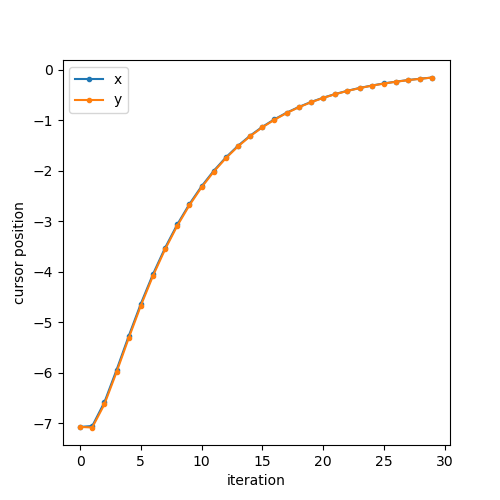

<IPython.core.display.Javascript object>


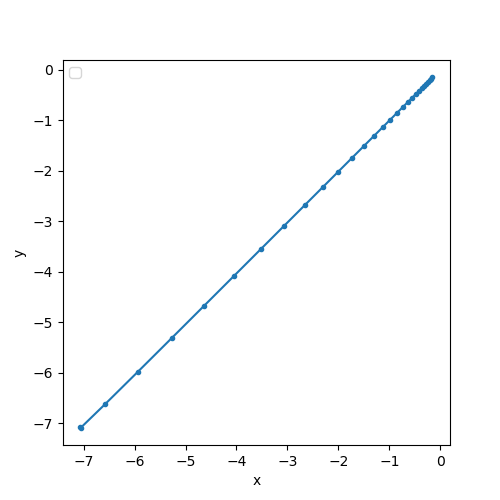

In [149]:
num_plot = 30
x = state_da.loc['kin_px',np.arange(0,num_plot)]
y = state_da.loc['kin_py',np.arange(0,num_plot)]
# x = state_da.loc['kin_px',:]
# y = state_da.loc['kin_py',:]

#each coordinate: 
plt.figure(figsize=(5,5))
plt.plot(x,'.-',label='x')
plt.plot(y,'.-',label='y')
plt.xlabel('iteration')
plt.ylabel('cursor position')
plt.legend()

#trajectory
plt.figure(figsize=(5,5))
plt.plot(x,y,'.-')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

### Methods to solve discrete algebraic riccati equations that didn't work: 

In [ ]:
import scipy.linalg

In [ ]:
P=scipy.linalg.solve_discrete_are(A,B,Q,R)

In [ ]:
import control

In [ ]:
control.dare(np.array(A),np.array(B),np.array(Q),np.array(R))